# Watershed analysis with pysheds

In this case study we will cover how to extract watersheds and perform some example analyses using the elevation data in each watershed.

## Introduction

The goal of this case study is to analyze digital elevation from a set of watersheds along the western side of the Southern Alps of New Zealand. In particular, we will focus on watersheds that are in the immediate hanging wall of the Alpine Fault, where the fault motion is rapidly uplifting the landscape at the same time rivers and glaciers are carving their way into it. The goal is to see how various values we can calculate for each watershed vary and what they can tell us about how rivers and glaciers may have shaped the surface within each watershed. We will start by going through the steps to prepare the digital elevation data, then show you how to extract data for a single watershed, and finally we will automate the process and produce an interactive map including values we have calculated for each watershed similar to Figure 12.1.

![_**Figure 12.1**. The Cook River watershed (purple) in New Zealand upstream of the Alpine Fault (black line)._](../img/cook-river-watershed.png)

_**Figure 12.1**. The Cook River watershed (purple) in New Zealand upstream of the Alpine Fault (black line)._

To get started, we'll present a quick overview of some of the key background topics, as this could be a new topic for some readers. If you're already familiar with delineating watersheds and things like basin hypsometry, feel free to skip ahead to Section 10.1.2 Getting started.

### A brief introduction to watershed analysis

Watershed analysis is the process of analyzing the landscape and hydrology of *{term}`watersheds <watershed>`* – land areas where surface water drains to a common outlet, such as a river, lake, or ocean. In our case we are interested in understanding how various factors, such as the area and/or topographic relief, vary within a set of river watersheds in the Southern Alps to be able to explore relationships related to landscape uplift and erosion. Thus, we will calculate a series of values for each watershed and then investigate how they vary within the study area.

In order to perform our analysis, we will need to complete a series of steps including loading the digital elevation data for the study region, defining the areas of the watersheds of interest, analyzing the landscapes in each watershed, and visualizing the results. In the following sections we will explore each of these topics in more detail and demonstrate how to perform watershed analysis using Python.

## Getting started

We can start by importing the libraries we need for this analysis. In this case, we will be using `xarray`, `rioxarray`, `pysheds`, `geopandas`, and `geocube` in addition to more familiar packages such as `matplotlib` and `numpy`. We will also use some custom functions from the `basin_functions.py` file, which you are welcome to check out if you want to know more about how the functions work.

In [1]:
# Note that we import everything here but have a "fake import" Markdown cell below.
# This is because a warning is raised by importing from pysheds.grid
# and suppressing the warning message did not work.
from basin_functions import *
from geocube.vector import vectorize
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from pysheds.grid import Grid
from pysheds.view import Raster, ViewFinder
import rioxarray as rxr
import xarray as xr

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


```python
from basin_functions import *
from geocube.vector import vectorize
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from pysheds.grid import Grid
from pysheds.view import Raster, ViewFinder
import rioxarray as rxr
import xarray as xr
```

We can also set the plotting style for the visualizations using [`matplotlib` style sheets](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html).

In [2]:
# Set plotting style
plt.style.use("bmh")

### Loading the digital elevation data

A mosaic of the data used for this case study has already been created and is provided as a geotiff image online at the address listed with the variable `bucket_dem_fp` below. This digital elevation model (DEM) covers the central portion of the southern island of New Zealand. The DEM data is from the [ALOS World 3D-30m digital surface model](https://www.eorc.jaxa.jp/ALOS/en/dataset/aw3d30/aw3d30_e.htm) [^alos] with approximately 30 m spatial resolution (e.g., {cite}`Tadono2014`). Information about how the data have been processed to produce the mosaic we will use can be found in the {doc}`data for New Zealand section </data/New-Zealand-data>` online. We will be using this elevation data to extract and analyze river drainage basins on the western side of the New Zealand Alps.

To start, we can read in the data using `rioxarray`.

In [3]:
# S3 bucket containing the data
bucket_home = "https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/PythonGIS/"
bucket_dem_file = "elevation/new_zealand/south_island_nz.tif"
bucket_dem_fp = bucket_home + bucket_dem_file

# Read the input data file
south_island = rxr.open_rasterio(bucket_dem_fp).drop_vars("band")[0]

Now we can have a look at the data in a bit more detail by printing out the `xarray` `DataArray` called `south_island`.

In [4]:
south_island

<xarray.DataArray (y: 10800, x: 18000)> Size: 389MB
[194400000 values with dtype=int16]
Coordinates:
  * x            (x) float64 144kB 167.5 167.5 167.5 167.5 ... 172.5 172.5 172.5
  * y            (y) float64 86kB -41.8 -41.8 -41.8 -41.8 ... -44.8 -44.8 -44.8
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:  1
    TIFFTAG_YRESOLUTION:  1
    AREA_OR_POINT:        Area
    scale_factor:         1.0
    add_offset:           0.0

As we can see above we have a dataset with around 194 million elevations (18000 longitude points and 10800 latitude points). The values at each point are the elevation of the surface or `NaN` if the points are below sea level or missing from the DEM.

## Extracting watersheds using pysheds

### Overview of watershed delineation

The next step in our workflow is to load the DEM into `pysheds` [^pysheds] to start working on the steps to define the boundaries of the watersheds. `pysheds` is a Python library designed for [efficient processing of DEM data and extraction of watersheds](https://mattbartos.com/pysheds/). However, before we get into using `pysheds`, it would be good to review some of the steps needed to define boundaries of watersheds.

The process of watershed delineation is essentially defining the points that lie upstream (or up slope) of a specified outlet point on a digital elevation model. Outlet points can be found various ways, and in this case study they were simply selected visually from [Google Maps](https://www.google.com/maps) by finding the locations where rivers along the western side of the New Zealand Alps between roughly 42.4 °S and 44.0 °S exit their valleys. This latitude range corresponds roughly to a long, linear segment of the [Alpine Fault](https://en.wikipedia.org/wiki/Alpine_Fault), the boundary between the Australian and Pacific tectonic plates.

However, once outlet points have been selected, there are still several important steps for processing a DEM such that watersheds can be defined. For instance, the DEM must be updated such that a route to the outlet points can be found using the assumption that water will flow to neighboring cells at lower elevations. The first set of steps are collectively referred to as "hydrological conditioning" of the DEM. Conditioning steps include:

- Filling pits in the DEM. Pits are individual cells in the DEM that have no neighbor cell with a lower elevation (outlet). The elevations of pits must be increased to the point that their height is equal to or greater than at least one neighbor cell.
- Filling depressions in the DEM. Similar to filling pits, groups of cells that have no outlet (depressions) must be filled (have their elevation increased) such that the elevation is equal to or greater than at least one neighbor cell.
- Resolving flats. Water cannot flow downhill in flat regions of a DEM, such as a lake. Thus, flat regions in the DEM also need to be corrected such that water can always flow to a downstream outlet.

Once the DEM has been conditioned, there are a few additional steps needed to produce the necessary information for watershed delineation, which are performed using the updated DEM. These steps include:

- Determining flow directions. In order to be able to define the watershed it is necessary to identify all DEM cells where water would be routed to the defined watershed outlet. Flow directions indicate the direction in which water would be expected to flow from every cell in the DEM, which allows the directions to be traced upstream from the outlet to the point where flow directions diverge at the boundary of the watershed.
- Determining flow accumulation. Flow accumulation is a calculation of how many upstream cells drain into each cell in the DEM. This isn't strictly needed for watershed delineation, but can be helpful in finding river channels in the DEM if selected outlet points are not located exactly in a channel cell. We will return to this below.

Once these steps have been completed, it is possible to delineate a watershed upstream of a specified outlet point.

### Reading the DEM into pysheds

At this stage we can begin the DEM processing steps using `pysheds`. The first step is to read in the DEM. To do this, we need to define the elevation data that will be used (`data`), the affine transformation matrix (`affine`), the coordinate reference system (`crs`), and the value used to indicate missing data (`nodata`). As a reminder, the affine transformation matrix and coordinate reference system values were introduced in Sections 7.2 and 7.4. The values used in the case are defined below.

And it is worthwhile to note that it is also possible to read geotiff DEMs into `pysheds` directly. In this case study, the data are read in using `rioxarray` because we have seen this before and {doc}`pre-processing of the data was done to create a mosaic </data/New-Zealand-data>` using `rioxarray`. As a reminder, creating mosaics of raster data was covered in Section 7.3.

In [5]:
data = south_island.data
affine = south_island.rio.transform()
crs = south_island.rio.crs
# Keep same data type as DEM values for nodata
nodata = data.dtype.type(-9999)

The values above can then be used to define the `pysheds` `ViewFinder`, which defines the spatial reference system for the DEM. After defining the `ViewFinder`, the elevation data can be read in using the `pysheds` `Raster()` function.

In [6]:
viewfinder = ViewFinder(affine=affine, shape=data.shape, crs=crs, nodata=nodata)
dem = Raster(data, viewfinder=viewfinder)

Finally, a `pysheds` `Grid` object is created, which allows visualization of the DEM data and the use of various `Grid` methods for processing the elevation data.

In [7]:
# Create grid
grid = Grid.from_raster(dem)

### Preparing a DEM for analysis in pysheds

Now we are ready to begin processing the data. As noted above, we're working with a fairly large DEM (~194 million points). Before continuing, we note here that some output plots and supplementary information are provided only in the online version of this book at <https://pythongis.org>. These additional materials are not presented in the print version of the book to save space (and are not needed to understand this case study).

The processing of the data with `pysheds` generally goes smoothly, but it is possible that the JupyterLab kernel might crash at some stage. As a result, we will use an additional variable below (`checkpoint`), which will write output to files at different stages and allow us to restart the processing from various points if the kernel crashes. If you do not want to want checkpoint output written to the `checkpoint_data` directory, set `checkpoint` to `False`.

In [8]:
checkpoint = True
if checkpoint:
    # Create checkpoint_data directory if it does not exist
    wd = Path.cwd()
    newdir = wd / "checkpoint_data"
    newdir.mkdir(parents=True, exist_ok=True)

The first step in the process is to detect any pits in the DEM, which can be done using the `.detect_pits()` `Grid` method.

In [9]:
# Detect number of pits in DEM
pits = grid.detect_pits(dem)
npits = np.count_nonzero(pits)

# Check number of pits
print(f"Number of pits found: {npits}")

Number of pits found: 626348


After detecting the pits it is possible to visualize their locations by plotting the `pits` values, as shown below. Unfortunately in this case, the number of elevations is so large that the 626,348 pits are not visible in the resulting plot. For smaller DEMs these points could be visible.

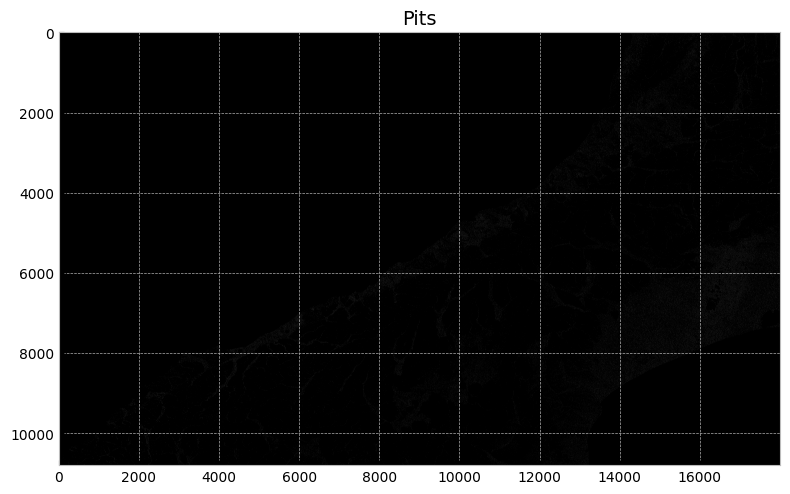

In [10]:
# Plot pits if more than zero
if npits > 0:
    # Plot pits
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.patch.set_alpha(0)

    plt.imshow(pits, cmap="Greys_r", zorder=1)
    plt.title("Pits", size=14)
    plt.tight_layout()

_Visualization of the pits detected in the raw DEM._

As there are clearly many pits in the DEM (626,348), it is necessary to next fill in the pits using the `.fill_pits()` method. After doing this, we can check that the pits have been filled using an `assert` statement.

In [11]:
# Fill pits and check they have been filled
pit_filled_dem = grid.fill_pits(dem)
pits = grid.detect_pits(pit_filled_dem)
assert not pits.any()

So, now all pits have been filled, but other depressions may still exist in the DEM, which we will now detect (and fill if they exist). We can detect depressions using the `detect_depressions()` method.

In [12]:
# Detect depressions - Slow. May take 5 minutes or more.
depressions = grid.detect_depressions(pit_filled_dem)

If we were to check the number of depressions like was done for the pits above, we would find there are zero depressions. However this is incorrect, and may be related to the large number of nodata values in the sea areas of the DEM we are working with. There are indeed some depressions that need to be filled, and we can do that below.

As was the case for the pits, it is possible to visualize the locations of depressions in the DEM. Again, however, no depressions are visible in the plot.

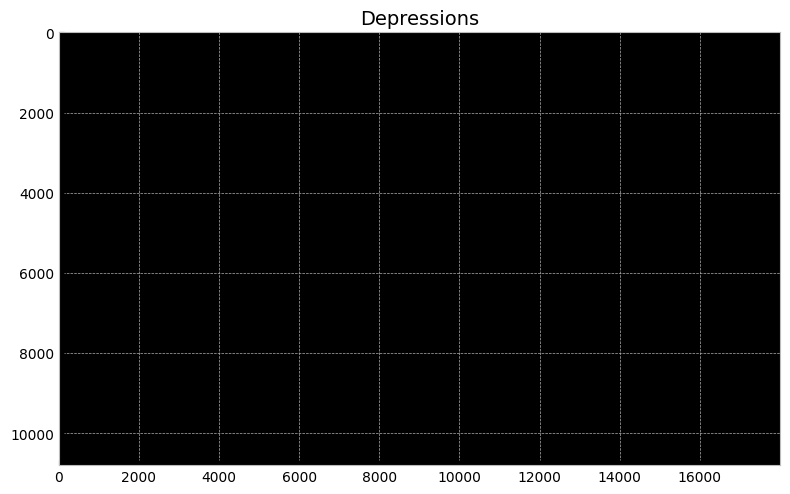

In [13]:
# Plot depressions - in case you would like to do so with other DEMs
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(depressions, cmap="Greys_r", zorder=1)
plt.title("Depressions", size=14)
plt.tight_layout()

_Visualization of the depressions detected in the pit-filled DEM._

### Writing output to file

Since detecting the depressions can take a few minutes, this is a good point to use the `checkpoint` variable to save the current output to a file in case there is a need to restart the notebook. We can write out the values from the DEM with pits filled (`pit_filled_dem`) and detected depressions (`depressions`) to separate files using the `.to_raster()` method of `pysheds`. Details about writing data to files in `pysheds` can be found in the `pysheds` [File I/O documentation](https://mattbartos.com/pysheds/file-io.html) [^fileio].

In [14]:
if checkpoint:
    # Write dataset to file
    grid.to_raster(
        pit_filled_dem,
        "checkpoint_data/pit_filled_dem.tif",
        blockxsize=16,
        blockysize=16,
    )
    # NOTE: Need to use "int" for dtype to avoid write error for boolean values
    grid.to_raster(
        depressions,
        "checkpoint_data/detected_depressions.tif",
        dtype=int,
        blockxsize=16,
        blockysize=16,
    )

We have now written output to files and thus it is possible to restart the analysis from this point. You can read in the output data in the cell below (if desired) by setting `continue_from_here` to be `True`.

In [15]:
continue_from_here = False
if continue_from_here:
    grid, pit_filled_dem = continue_pysheds("checkpoint_data/pit_filled_dem.tif")
    _, depressions = continue_pysheds("checkpoint_data/detected_depressions.tif")

### Preparing a DEM for analysis in pysheds (continued)

The next step in the analysis is to fill depressions. Depressions can be filled using the `.fill_depressions()` method. As above, we can use an `assert` statement to ensure there are not remaining depressions in the DEM.

In [16]:
# Fill depressions - Slow, takes 5-10 minutes...
flooded_dem = grid.fill_depressions(pit_filled_dem)
depressions = grid.detect_depressions(flooded_dem)
assert not depressions.any()

If the `checkpoint` option is being used, the cell below provides the option to write `flooded_dem` to file using the same approach as above for the pit-filled DEM.

In [17]:
if checkpoint:
    # Write dataset to file
    grid.to_raster(
        flooded_dem, "checkpoint_data/flooded_dem.tif", blockxsize=16, blockysize=16
    )

In [18]:
continue_from_here = False
if continue_from_here:
    grid, pit_filled_dem = continue_pysheds("checkpoint_data/pit_filled_dem.tif")
    _, depressions = continue_pysheds("checkpoint_data/detected_depressions.tif")
    _, flooded_dem = continue_pysheds("checkpoint_data/flooded_dem.tif")

Now that all depressions and pits in the DEM have been filled, we can proceed to handling flow routing across flats (such as lakes) in the DEM. We will first detect if there are any flats using the `.detect_flats()` method.

In [19]:
# Detect flats
flats = grid.detect_flats(flooded_dem)
nflats = np.count_nonzero(flats)

# Check number of flats
print(f"Number of flats found: {nflats}")

Number of flats found: 113782859


Looks like we have plenty of flat regions in the DEM! 

As was the case earlier, it is possible to visualize the locations of flat regions in the DEM by plotting the `flats` values. In contrast to the case for the pits and depressions above, visualizing the flat regions in the DEM clearly shows their locations.

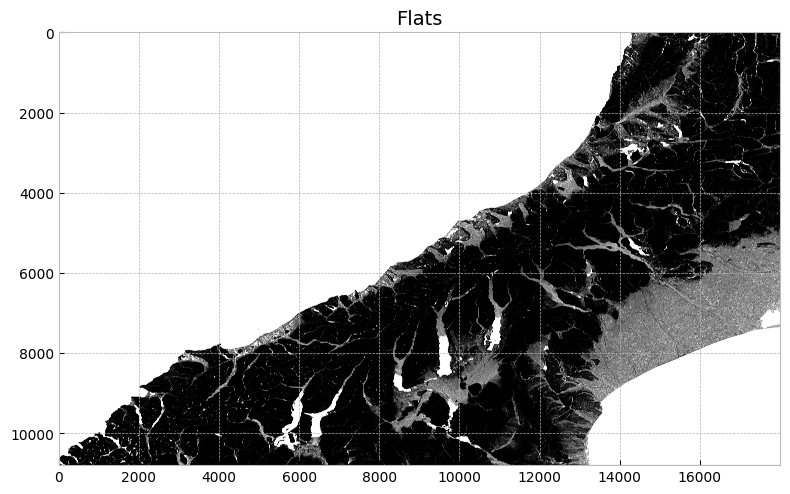

In [20]:
# Plot flats
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(flats, cmap="Greys_r", zorder=1)
plt.title("Flats", size=14)
plt.tight_layout()

_Visualization of the flats detected in the flooded DEM._

Flat regions in the DEM can be handled by processing the flooded DEM to determine how water would be routed across the flat regions. In `pysheds`, this can be done using the `.resolve_flats()` method.

In [21]:
# Resolve flats
inflated_dem = grid.resolve_flats(flooded_dem)

Now that we have resolved the flat regions it is possible to move on to the steps related to determining flow directions and flow accumulation.

### Calculating values related to surface water flows

At this stage we can use the inflated DEM (with flats resolved) to determine two key things: (1) the direction water flows at all points on the surface of the DEM (flow direction), and (2) the number of cells draining into each cell in the DEM (flow accumulation). Flow directions can be calculated using the `.flowdir()` method and flow accumulation can be calculated using the `.accumulation()` method, as shown below.

In [22]:
# Compute flow direction based on corrected DEM (D8)
fdir = grid.flowdir(inflated_dem)

# Compute flow accumulation based on computed flow direction
acc = grid.accumulation(fdir)

As was the case earlier, we can again check the values for the flow directions and flow accumulation by creating a plot of them. Here, we can plot the flow accumulation (`acc`) to see how things look.

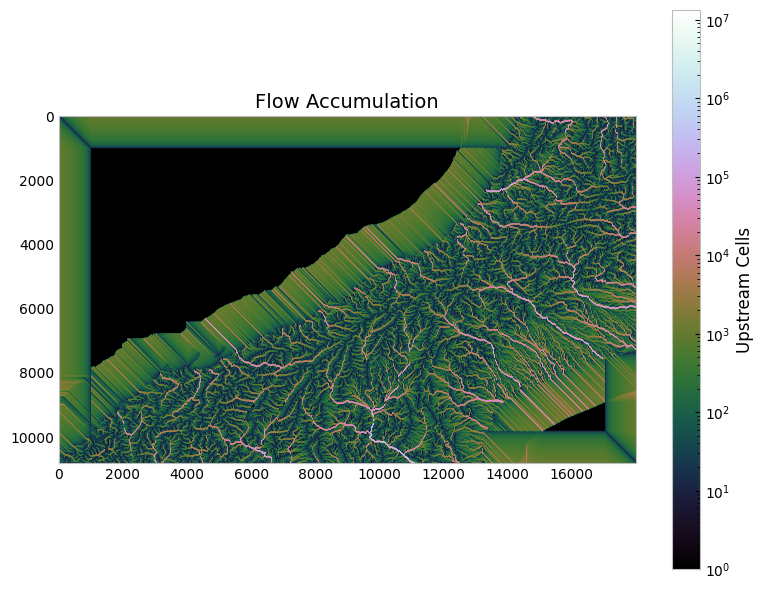

In [23]:
# Plot flow accumulation, if requested
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
im = ax.imshow(
    acc,
    zorder=2,
    cmap="cubehelix",
    norm=colors.LogNorm(1, acc.max()),
    interpolation="bilinear",
)
plt.colorbar(im, ax=ax, label="Upstream Cells")
plt.title("Flow Accumulation", size=14)
plt.tight_layout()

_Visualization of the flow accumulation calculated using the inflated DEM._

In [24]:
if checkpoint:
    # Write flow accumulation and directions to file
    grid.to_raster(
        acc, "checkpoint_data/flow_accumulation.tif", blockxsize=16, blockysize=16
    )
    grid.to_raster(
        fdir, "checkpoint_data/flow_directions.tif", blockxsize=16, blockysize=16
    )

In [25]:
continue_from_here = False
if continue_from_here:
    grid, pit_filled_dem = continue_pysheds("checkpoint_data/pit_filled_dem.tif")
    _, depressions = continue_pysheds("checkpoint_data/detected_depressions.tif")
    _, flooded_dem = continue_pysheds("checkpoint_data/flooded_dem.tif")
    _, acc = continue_pysheds("checkpoint_data/flow_accumulation.tif")
    _, fdir = continue_pysheds("checkpoint_data/flow_directions.tif")

### Defining and extracting a watershed

With the flow directions and accumulation calculated, we can proceed to the steps for extracting a watershed that can be further analyzed. We will proceed through the steps for a single watershed before returning to the workflow to batch process a group of 38 rivers and creeks that drain the western side of the Southern Alps. Note that within this section the terms "watershed" and "catchment" will be used interchangeably, as some of the tools in `pysheds` use the term "catchment."

In order to get started, we need to select a river outlet and specify its location. In this case we can use the Waiho River in the central part of the study area. The outlet location (170.182282 °E, 43.394347 °S) is defined as a Python tuple in the cell below.

In [26]:
outlet = (170.182282, -43.394347)

Once the `outlet` location is defined we can use the `.catchment()` function to define the area of the watershed/catchment. However, we will take one additional step here. Sometimes the location of the outlet coordinates does not fall directly within the channel location in the DEM, which can lead to defining smaller parts of the watershed (e.g., tributary streams) instead of the full desired watershed area. To help with this, `pysheds` has a `.snap_to_mask()` function that will adjust the specified `outlet` point to the nearest cell with a "high" flow accumulation (at least 1000 in this case). This will ensure that the point specified as `outlet` captures the full upstream drainage area.

In [27]:
# Snap outlet point to nearby cell with high flow accumulation
x_snap, y_snap = grid.snap_to_mask(acc > 1000, outlet)

# Delineate the watershed
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, xytype="coordinate")

Now that we have extracted the watershed we can visualize and inspect the results. For the sake of demonstration we will look at four subplots of watershed data (Figure 12.2) produced from the cell below: (1) the watershed extent, (2) the watershed elevations, (3) the watershed flow directions, and (4) the watershed flow accumulation. These are plotted using the `matplotlib.pyplot` function `.imshow()`, and otherwise use plotting syntax that should be familiar from Chapter 4.

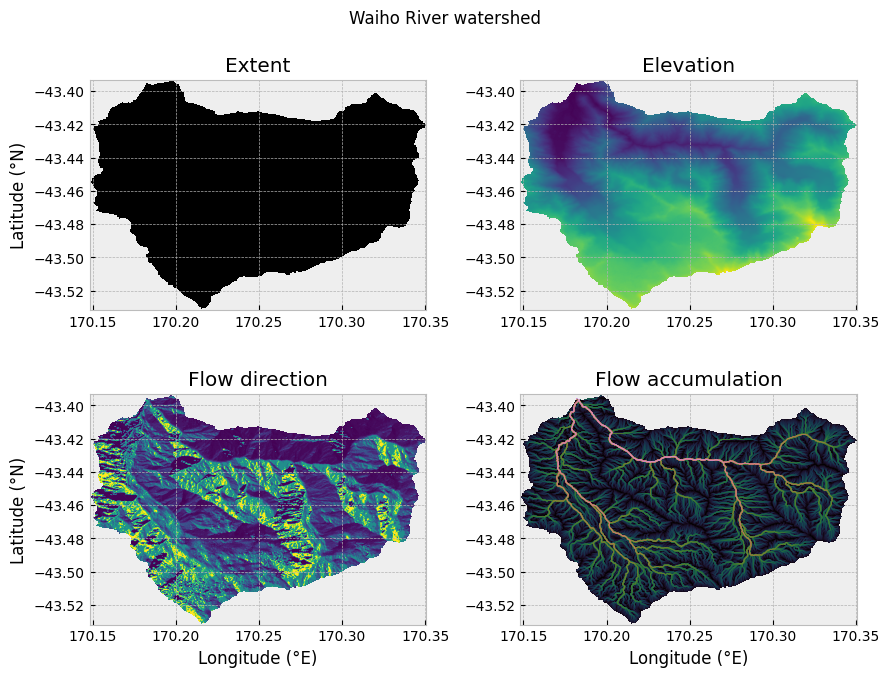

In [28]:
# Clip and set view extents
grid.clip_to(catch)
catch_view = grid.view(catch, nodata=np.nan)
fdir_view = grid.view(fdir, nodata=np.nan)
acc_view = grid.view(acc, nodata=np.nan)
dem_view = grid.view(dem, nodata=np.nan)

# Create figure and plot axes
fig, axes = plt.subplots(2, 2, figsize=(9, 7))
fig.patch.set_alpha(0)

# Plot watershed extent
im = axes[0, 0].imshow(catch_view, extent=grid.extent, zorder=1, cmap="Greys_r")
axes[0, 0].set_title("Extent")
axes[0, 0].set_ylabel("Latitude (°N)")

# Plot watershed elevations
im = axes[0, 1].imshow(dem_view, extent=grid.extent, zorder=1, cmap="viridis")
axes[0, 1].set_title("Elevation")

# Plot watershed flow directions
im = axes[1, 0].imshow(fdir_view, extent=grid.extent, zorder=1, cmap="viridis")
axes[1, 0].set_title("Flow direction")
axes[1, 0].set_xlabel("Longitude (°E)")
axes[1, 0].set_ylabel("Latitude (°N)")

# Plot watershed flow accumulation
im = axes[1, 1].imshow(
    acc_view,
    extent=grid.extent,
    zorder=2,
    cmap="cubehelix",
    norm=colors.LogNorm(1, acc.max()),
    interpolation="bilinear",
)
axes[1, 1].set_title("Flow accumulation")
axes[1, 1].set_xlabel("Longitude (°E)")

# Add a figure title
plt.suptitle("Waiho River watershed")
plt.tight_layout()

_**Figure 12.2**. Waiho River watershed extent, elevations, flow directions, and flow accumulation._

## Analyzing the watershed data

Having extracted the watershed area, there are a handful of additional analyses we can perform using `pysheds`. A good place to start is by calculating the distance from each point in the watershed to the defined outlet point. This provides a measure of how many cells water must flow across to reach the outlet, which can be converted to a distance in meters. We can use the `pysheds` `.distance_to_outlet()` function for this calculation.

In [29]:
# Compute distance to outlet
dist = grid.distance_to_outlet(
    x=x_snap,
    y=y_snap,
    fdir=fdir,
    xytype="coordinate",
)

Similar to the plot above of the catchment data, we can plot the distance to the outlet using `.imshow()`.

Text(0.5, 1.0, 'Distance to outlet')

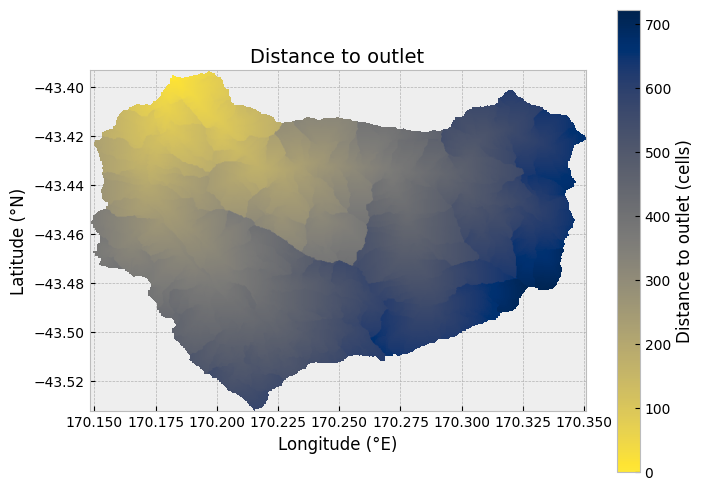

In [30]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

# Plot distance to outlet
im = ax.imshow(dist, extent=grid.extent, zorder=2, cmap="cividis_r")

# Add colorbar, axis labels, and a title
plt.colorbar(im, ax=ax, label="Distance to outlet (cells)")
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.title("Distance to outlet", size=14)

_**Figure 12.3**. Cell distances to defined outlet for the Waiho River watershed._

It is also possible to extract the network of channels in the watershed using the `pysheds` function `.extract_river_network()`. This will identify all regions of the flow accumulation grid where the accumulation exceeds a given threshold (parameter `acc`). In our case, all regions with an accumulation of over 100 cells will be identified. In addition, the channel segments are plotted using different colors to indicate when there are channel segments than join (channel junctions).

In [31]:
# Extract river network
branches = grid.extract_river_network(fdir, acc > 100)

After calculating the branches, they can be plotted using the `matplotlib` plotting function `plt.plot()`.

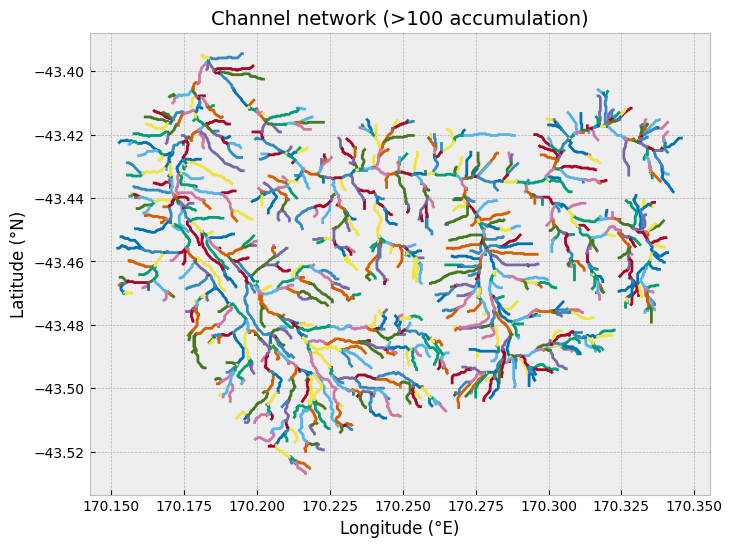

In [32]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot channel segments
for branch in branches["features"]:
    line = np.asarray(branch["geometry"]["coordinates"])
    plt.plot(line[:, 0], line[:, 1])

# Add axis labels and title
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.title("Channel network (>100 accumulation)", size=14);

_**Figure 12.4**. Channel segments for the Waiho River watershed._

### Exporting the watershed data to xarray

While it is also possible to perform other watershed analyses using `pysheds` (check the [`pysheds` documentation](https://mattbartos.com/pysheds/) for more examples [^pysheds]), the next set of analyses relies on exporting our watershed elevation data from `pysheds` to `xarray`. Exporting to `xarray` will allow us to easily interact with the elevation data for the watershed, including performing analyses of the watershed elevations such as calculating the watershed hypsometry and hypsometric integral. In order to export the watershed elevations to `xarray` we need to extract the elevations themselves, as well as the latitude and longitude values for the watershed. Once those values have been extracted, an `xarray` `DataArray` can be created using the `DataArray` function, as shown below.

In [33]:
# Convert watershed data for xarray
catchment = dem_view
data = catchment.data

# Get latitude and longitude ranges
lat = np.unique(catchment.coords[:, 0])
# Get latitude points in correct order (reverse order of array values)
lat = np.flip(lat)
lon = np.unique(catchment.coords[:, 1])

# Create DataArray
catch_xr = xr.DataArray(catchment.base, coords={"y": lat, "x": lon}, dims=["y", "x"])

That was easy! We will be using this approach later in this case study when we automate the processing of all 38 watersheds in the study area, so this might be a good case for creating a function to perform the conversion steps. Just such a function is provided for you in the `basin_functions.py` file wiht the name `to_xarray()`.

We can confirm that the conversion has gone as expected by plotting the watershed data using the `xarray` `.plot()` function.

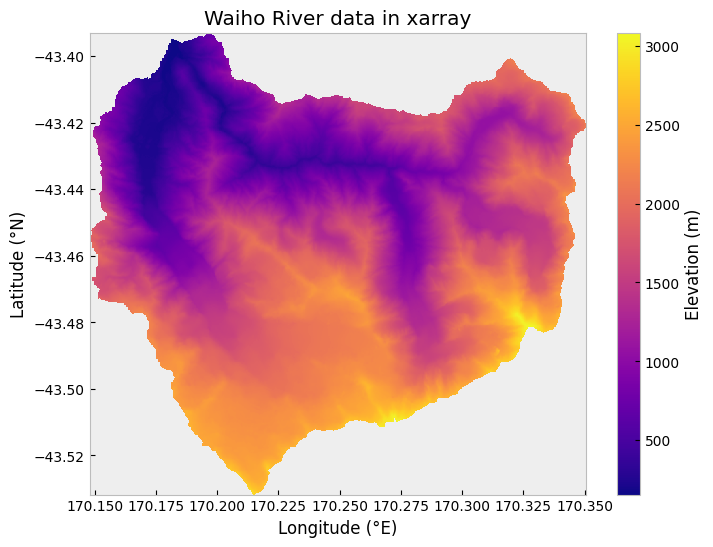

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

catch_xr.plot(ax=ax, cmap="plasma", cbar_kwargs={"label": "Elevation (m)"})
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_title("Waiho River data in xarray");

_Visualization of the Waiho River watershed elevations in `xarray`._

### Calculating basin hypsometry

Our next major step is to calculate a hypsometric integral for the basin, which can provide an estimate of the volume of material in the watershed that has been eroded by rivers and glaciers. *{term}`Hypsometry <hypsometry>`* (or hypsometric analysis) refers to the measurement of the distribution of elevations of Earth's (or other planet's) surface elevations within a given area. In essence, it is a means to explore how much land area is within different elevation ranges, similar to calculating a histogram of elevations. On Earth, for instance, we can observe that [the majority of land area is at elevations within 800 meters of sea level, while little land area is at elevations greater than three kilometers](https://en.wikipedia.org/wiki/Hypsometry) [^elevations]. Hypsometric analysis of watersheds refers to the measurement of the distribution of elevations within a watershed (or drainage basin). A common product of hypsometric analysis of a watershed is a *{term}`hypsometric curve`*, which shows the distribution of watershed area above a given elevation in the watershed (i.e., a cumulative distribution). The elevation range and areas of hypsometric curves are often normalized to allow comparison between various watersheds (e.g., Figure 12.5).

![_**Figure 12.5**. Example normalized hypsometric curve for a watershed._](../img/hypsometric-curve.png)

_**Figure 12.5**. Example normalized hypsometric curve for a watershed._

So, why do we care about the hypsometry of a watershed? There are a few reasons. One is the fact that the distribution of elevations in a drainage basin can tell us something about the geological processes that have shaped the land surface in the drainage basin. Rivers and glaciers carve their valleys into the underlying soil/rock at the surface in watersheds, eroding the landscape and altering the distribution of elevations within the basin. However, valley glaciers tend to form broad, deep valleys and remove more mass from a watershed than rivers would, which is something that would often be reflected in the hypsometry of the watershed. In a classic article, {cite}`Strahler1952` presented the concept of the *{term}`hypsometric integral`*, which is a single value that can be calculated by integrating the normalized hypsometric curve. Glaciated watersheds often experience more erosion of the rock within the watershed than fluvial watersheds, and the decreased volume of rock in the catchment is reflected in watershed areas concentrated at lower elevations and a lower hypsometric integral. We will explore hypsometry and hypsometric integrals in greater detail below. 

Calculating the basin hypsometry involves determining the frequency distribution of elevation within a given watershed. In other words, we want to know how frequent (in terms of the number of DEM cells) elevations occur within given elevation ranges, such as 600–800 m above sea level. The simplest way to do this us by calculating a histogram of elevations for the watershed, which can be done using the `numpy` function `numpy.histogram()`. To perform the calculation, we need both the set of elevations for the entire watershed and the number of bins to use when calculating the elevation ranges. If we use 20 bins, for example, we could calculate the elevation histogram as follows. Note: we are excluding the NoData values explicitly from the dataset using `~np.isnan(catch_xr.values)` to get only the values are are not NoData.

In [35]:
catchment_elevations = catch_xr.values[~np.isnan(catch_xr.values)]
nbins = 20
counts, bins = np.histogram(catchment_elevations, bins=nbins)

The resulting histogram can be plotted as well, just to see how things look. However, plotting the output from histograms calculated using `numpy` is a bit clumsy with `matplotlib`, so we can instead use the `matplotlib` `pyplot.hist()` function to check out the elevation histogram.

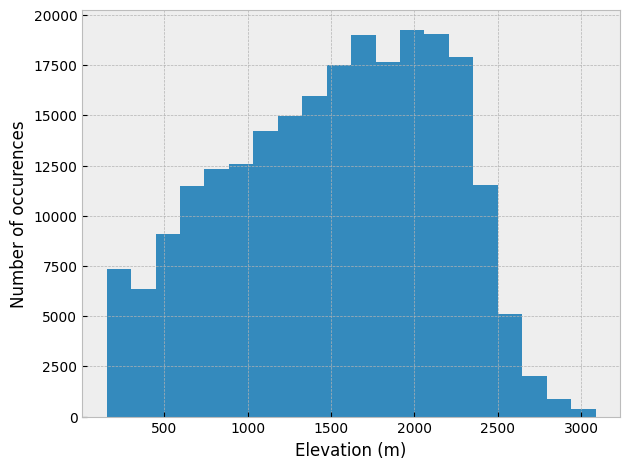

In [36]:
# Create figure and axis
fig, ax = plt.subplots(1, 1)

# Plot elevation histogram
ax.hist(catchment_elevations, bins=nbins)

# Add axis labels
ax.set_xlabel("Elevation (m)")
ax.set_ylabel("Number of occurences")
plt.tight_layout()

_Elevation histogram for the Waiho River watershed with 20 bins._

Instead of calculating a histogram with a fixed number of elevation bins, an alternative is to do the calculation with a specified elevation range for each bin. To do this we need to do a few extra calculations, but will end up with better control on how the elevations are binned irrespective of the range of elevations in the watershed. Let's consider the case with a 50 meter elevation bin size (`binsize = 50.0`). We can calculate the number of bins and histogram values as follows.

In [37]:
# Define bin elevation range
binsize = 50.0

# Determine the bounds for the minimum and maximum bins
minbin = catchment_elevations.min() - catchment_elevations.min() % +binsize
maxbin = catchment_elevations.max() - catchment_elevations.max() % -binsize

# Calculate number of bins and histogram
nbins = np.arange(minbin, maxbin + 1.0, binsize)
counts, bins = np.histogram(catchment_elevations, bins=nbins)

The resulting histogram can be plotted using the `matplotlib` `pyplot.hist()` function. Looking at the resulting plot, it appears the 50-meter elevation binning worked as expected.

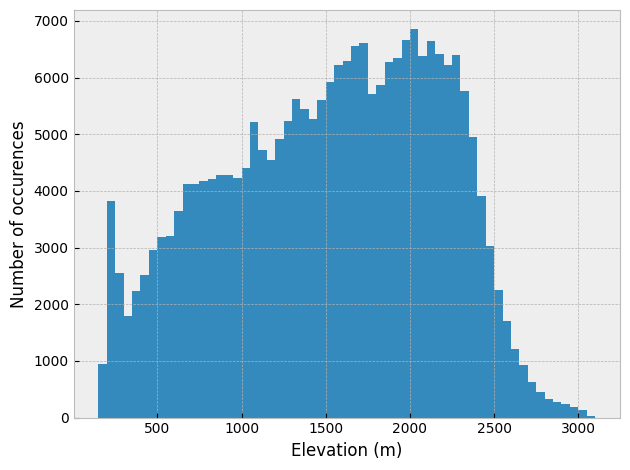

In [38]:
# Create figure and axis
fig, ax = plt.subplots(1, 1)

# Plot elevation histogram
ax.hist(catchment_elevations, bins=nbins)

# Add axis labels
ax.set_xlabel("Elevation (m)")
ax.set_ylabel("Number of occurences")
plt.tight_layout()

_**Figure 12.6**. Elevation histogram for the Waiho River watershed with a 50-meter bin size._

The hypsometry of the watershed relies on finding the proportion of elevations above a given point from the lowest elevation to the highest in the basin. We can use the histogram data for this but we need to do a few things. First, a cumulative sum of the histogram elevation distribution should be calculated. In addition, the cumulative distribution should be reversed such that the elevation fraction is 1.0 (or 100%) above the minimum elevation and 0.0 (or 0%) above the maximum. Finally, the elevation distribution and ranges should be normalized to one, as this will make it easier to compare distributions for different watersheds.

In [39]:
# Calculate (normalized) cumulative distribution
norm_counts = counts.cumsum() / counts.cumsum().max()

# Convert to area above min elevation
norm_counts = 1 - norm_counts

# Normalize elevation ranges
norm_bins = (bins - bins.min()) / (bins.max() - bins.min())

At this point we can use the normalized elevation distribution and ranges to calculate the hypsometric integral for the watershed and create a plot of the hypsometric curve. Because the elevations and areas have been normalized already, we can simply sum the product of the occurrences of each area multiplied by the width of the normalized bins.

In [40]:
# Calculate hypsometric integral
bin_width = norm_bins[1] - norm_bins[0]
hyps_integral = sum(norm_counts * bin_width)
print(f"Hypsometric integral: {abs(hyps_integral):.3f}")

Hypsometric integral: 0.457


What we can see here is that because the hypsometric integral value is lower than 0.5, a bit more than half of the volume of rock in the watershed is missing (due to erosion, for example). To help visualize this result we can plot the hypsometric curve along with a linear reference line for a hypsometric integral of 0.5, as shown below.

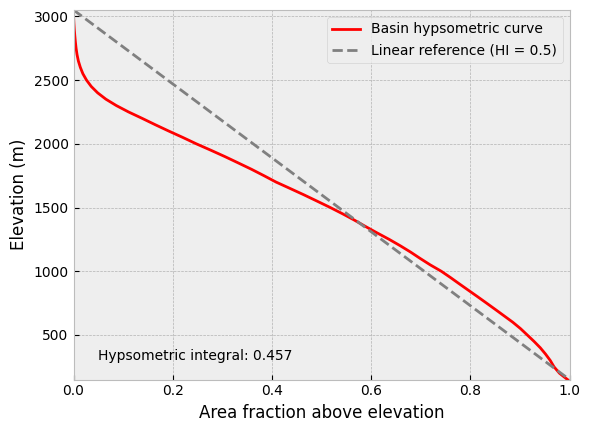

In [41]:
fig, ax = plt.subplots(1, 1)
# ax.plot(bins[:-1], counts, "k+")
ax.plot(norm_counts, bins[:-1], "r", label="Basin hypsometric curve")
ax.set_xlabel("Area fraction above elevation")
ax.set_ylabel("Elevation (m)")
ax.plot(
    [0.0, 1.0],
    [bins[:-1].max(), bins[:-1].min()],
    "--",
    color="gray",
    label="Linear reference (HI = 0.5)",
)
ax.legend()
ax.set_xlim(0.0, 1.0)
ax.set_ylim(bins[:-1].min(), bins[:-1].max())
ax.text(
    0.05,
    (0.05 * bins[:-1].max()) + bins[:-1].min(),
    f"Hypsometric integral: {abs(hyps_integral):.3f}",
);

_**Figure 12.7**. Hypsometric curve for the Waiho River watershed with a 50-meter bin size. HI = hypsometric integral._

## Automating the process

We have now gone through the process of conditioning a DEM, delineating a watershed, and analyzing the watershed data for the Waiho River watershed. Our next step is to automate this process for a larger set of 38 watersheds in the hanging wall of the Alpine Fault along the western side of the Southern Alps. In order to do this, we first need to create a pair of lists: one for the names of the watersheds, and a second for the locations of their outlets. In this case both lists were created by hand from selecting outlet point coordinates using [Google Maps](https://www.google.com/maps) [^maps].

In [42]:
river_names = [
    "Arawhata River",
    "Waiatoto River",
    "Turnbull River",
    "Okuru River",
    "Haast River",
    "Moeraki River",
    "Paringa River",
    "Mahitahi River",
    "Jacobs River",
    "Karangarua River",
    "Cook River",
    "Fox River",
    "Waikukupa River",
    "Omoeroa River",
    "Waiho River",
    "Waitangitaona River",
    "Darnley Creek",
    "Whataroa River",
    "Poerua River",
    "Wanganui River",
    "Waitaha River",
    "Kakapotahi River?",
    "Mikonui River",
    "Hokitika River",
    "Toaroha River",
    "Kokatahi River",
    "Styx River",
    "Arahura River",
    "Taipo River",
    "Taramakau River",
    "Crooked River",
    "Evans River",
    "Haupiri River",
    "Waikiti River",
    "Tutaekuri River",
    "Waiheke River",
    "Robinson River",
    "Blue Grey River",
]

And for each river or creek we have a corresponding outlet location or pour point (`pour_points`).

In [43]:
pour_points = [
    (168.723432, -44.060960),
    (168.838838, -44.023259),
    (168.942363, -43.971371),
    (168.987365, -43.952888),
    (169.144604, -43.935653),
    (169.351885, -43.785118),
    (169.497063, -43.716472),
    (169.593608, -43.666203),
    (169.695061, -43.617701),
    (169.808933, -43.576726),
    (169.965037, -43.498121),
    (170.008772, -43.478192),
    (170.070511, -43.443732),
    (170.102720, -43.425248),
    (170.182282, -43.394347),
    (170.274318, -43.343211),
    (170.302801, -43.326779),
    (170.403417, -43.285756),
    (170.525003, -43.217547),
    (170.624160, -43.158141),
    (170.729994, -43.107470),
    (170.820316, -43.064461),
    (170.869467, -43.014418),
    (171.012521, -42.957962),
    (171.131477, -42.910875),
    (171.150106, -42.903147),
    (171.165837, -42.884519),
    (171.238172, -42.840905),
    (171.405012, -42.755411),
    (171.467475, -42.733149),
    (171.626527, -42.649998),
    (171.682798, -42.618596),
    (171.733798, -42.612758),
    (171.886492, -42.568796),
    (171.979749, -42.559885),
    (171.995805, -42.546945),
    (172.012893, -42.471985),
    (172.136101, -42.411857),
]

With our lists of river/creek names and outlet locations ready, we can proceed to automating the watershed delineation and analysis steps presented earlier in this chapter for each watershed. To do this we will essentially perform the same steps presented earlier with a few minor modifications. First, because we want to store the outputs of the analysis steps separately, we will need to create a set of empty Python lists where output can be added for each watershed. We can also initialize a counter variable that will be updated with the catchment number each time a new watershed is processed.

In [44]:
# Create empty lists for storing outputs
catchment_numbers = []
catchment_lons = []
catchment_lats = []
catchment_areas = []
catchment_min_elevs = []
catchment_max_elevs = []
catchment_reliefs = []
catchment_his = []
catchment_boundaries = []

# Initialize catchment number for batch processing
catchment_number = 0

Next, we can create a large `for` loop that will be used to iterate over each watershed. We can use the length of the `pour_points` list to determine how many iterations to perform. Within each iteration we will execute the steps presented earlier. A summary of the steps is given below.

1. Set the grid extent to the extent of the full DEM
2. Snap the pour point to the nearest high-discharge cell
3. Delineate the watershed
4. Set the grid extent to that of the delineated watershed
5. Export the watershed data to `xarray`
6. Store the watershed elevations without the `nan` values and calculate the hypsometric integral
7. Extract a vector boundary of the watershed for plotting
8. Store the watershed data in the lists created above

    - Note: There are some functions from the `basin_functions.py` function that are used when appending values to the lists.
  
Now that we know the process, we can have a look at the code that is used for batch processing the watershed data.

In [45]:
print("Processing watersheds", end="")

for i in range(len(pour_points)):
    # Print a progress dot and increment catchment number
    print(".", end="", flush=True)
    catchment_number = i + 1

    # Reset grid extent
    grid.clip_to(dem)

    # Delineate the watershed
    x_snap, y_snap = grid.snap_to_mask(acc > 1000, pour_points[i])
    current_catchment = grid.catchment(
        x=x_snap, y=y_snap, fdir=fdir, xytype="coordinate"
    )

    # Clip and set view extent
    grid.clip_to(current_catchment)
    dem_view = grid.view(dem, nodata=np.nan)

    # Save watershed elevations in xarray
    catchment = dem_view
    data = catchment.data
    lat = np.unique(catchment.coords[:, 0])
    lat = np.flip(lat)
    lon = np.unique(catchment.coords[:, 1])
    catch_xr = xr.DataArray(
        catchment.base, coords={"y": lat, "x": lon}, dims=["y", "x"]
    )

    # Store elevations minus NaN values, calculate elevation histogram
    # and hypsometric integral
    catch_elev = catch_xr.values[~np.isnan(catch_xr.values)]
    counts, bins = calculate_hypsometry(catch_elev)
    hyps_integral = calculate_hypsometric_integral(counts, bins)

    # Extract vector boundary of watershed
    catch_xr.name = f"Watershed {catchment_number}"
    catch_gdf = vectorize(catch_xr.astype("float32"))
    catch_gdf = catch_gdf.dropna(subset=f"Watershed {catchment_number}")
    catch_gdf = catch_gdf.set_crs("epsg:4326")
    dissolved = catch_gdf.dissolve(method="unary")
    dissolved = dissolved.rename(columns={"geometry": "basin_boundary"})

    # Append watershed info to lists
    catchment_numbers.append(catchment_number)
    catchment_lons.append(pour_points[i][0])
    catchment_lats.append(pour_points[i][1])
    catchment_areas.append(round(calculate_area(catch_elev), 1))
    catchment_min_elevs.append(catch_elev.min())
    catchment_max_elevs.append(catch_elev.max())
    catchment_reliefs.append(calculate_relief(catch_elev))
    catchment_his.append(round(hyps_integral, 3))
    catchment_boundaries.append(dissolved["basin_boundary"].values[0])

print("done.")

Processing watersheds......................................done.


After completing the steps above we have nine lists full of catchment data that we will explore and visualize below.

### Plotting the results

In order to be able to interact with and explore our watershed data we will create an interactive map using `geopandas`. To get started with that process, we first need to take all of the data from the lists created in the previous section and assemble them in a `pandas` `DataFrame`. We can do so similar to how we introduced earlier in Section 3.1.9. After creating the `DataFrame` we can check the first rows of it using the `.head()` method.

In [46]:
data = {
    "Watershed number": catchment_numbers,
    "River name": river_names,
    "Outlet longitude (deg.)": catchment_lons,
    "Outlet latitude (deg.)": catchment_lats,
    "Area (sq. km)": catchment_areas,
    "Min. elevation (m)": catchment_min_elevs,
    "Max. elevation (m)": catchment_max_elevs,
    "Relief (m)": catchment_reliefs,
    "Hypsometric integral": catchment_his,
    "Basin boundary": catchment_boundaries,
}

catchment_df = pd.DataFrame(data)
catchment_df.head()

Watershed number      River name  Outlet longitude (deg.)  \
0                 1  Arawhata River               168.723432   
1                 2  Waiatoto River               168.838838   
2                 3  Turnbull River               168.942363   
3                 4     Okuru River               168.987365   
4                 5     Haast River               169.144604   

   Outlet latitude (deg.)  Area (sq. km)  Min. elevation (m)  \
0              -44.060960         1013.9               -24.0   
1              -44.023259          568.1                 1.0   
2              -43.971371          192.0                31.0   
3              -43.952888          277.9                 4.0   
4              -43.935653         1679.6                15.0   

   Max. elevation (m)  Relief (m)  Hypsometric integral  \
0              2933.0      2957.0                 0.326   
1              2946.0      2945.0                 0.326   
2              2058.0      2027.0                 0.443   
3              1968.0      1964.0                 0.392   
4              2676.0      2661.0                 0.352   

                                      Basin boundary  
0  MULTIPOLYGON (((168.33597222222227 -44.4923611...  
1  POLYGON ((168.71402777777783 -44.3798611111111...  
2  POLYGON ((168.9095833333334 -44.10069444444445...  
3  POLYGON ((168.97875000000002 -43.9787500000000...  
4  POLYGON ((169.14097222222227 -43.9754166666666...

Everything looks good so far, so we can now move on to creating a `geopandas` `GeoDataFrame` from the `catchment_df` `DataFrame` by explicitly assigning x and y coordinates and providing a coordinate reference system (WGS 84 in this case: `epsg:4326`).

In [47]:
catchment_df["geometry"] = gpd.points_from_xy(
    x=catchment_df["Outlet longitude (deg.)"], y=catchment_df["Outlet latitude (deg.)"]
)

catchment_gdf = gpd.GeoDataFrame(catchment_df, crs="epsg:4326")

The only remaining thing to do before creating the interact map is to load in data for the location of the [Alpine Fault](https://data.gns.cri.nz/af/) [^alpinefault] ({cite}`Langridge2016`). The data in this case comes from GNS Science, Te Pū Ao, New Zealand. For simplicity, we have created a `geopandas` `GeoPackage` containing the data that is available online.

In [48]:
# Read fault data from Geopackage
bucket_fault_file = "features/new_zealand/alpine_fault.gpkg"
bucket_fault_fp = bucket_home + bucket_fault_file

fault_df = gpd.read_file(bucket_fault_fp)

Now we are ready to plot the data and create an interactive map using `geopandas`. As we have several different things to plot, we will plot the data in three separate layers: (1) the Alpine Fault data, (2) the watersheds, and (3) the basin outlet points. For each layer we can use the `geopandas` `.explore()` function to create a map of the layer. Note that because we want to plot both the watershed boundaries and outlet points in separate layers, we need to specify the active geometry layer for `geopandas` before plotting each one.

In [49]:
# Plot Alpine Fault
m = fault_df.loc[fault_df["name"] == "Alpine Fault"].explore(
    column="name", cmap="gist_gray"
)

# Set active geometry layer and plot watersheds
catchment_gdf["Points"] = catchment_gdf["geometry"]
catchment_gdf = catchment_gdf.set_geometry("Basin boundary")
basin_color_field = "Hypsometric integral"
m = catchment_gdf.explore(
    m=m,
    column=basin_color_field,
    cmap="plasma",
)

# Set active geometry layer and plot outlet points
catchment_gdf = catchment_gdf.set_geometry("Points")
m = catchment_gdf.explore(m=m, color="black", marker_kwds={"radius": 2})
m

_**Figure 12.8**. An interactive map of watersheds along the western side of the Southern Alps, New Zealand._

## Concluding remarks

So now we have seen how to process and extract watersheds from digital elevation data, how to perform various analyses on the watershed data, and how to create an interactive map of the resulting outputs. This template can be used as it is, or easily augmented to fit your interests by changing the source data, types of analysis, or the formatting of the output map. And although there are a number of steps needed to perform such an analysis, automating the processing can allow the analysis to be scaled to large numbers of watersheds.

First, in terms of the output we have produced, we can perhaps also take a moment to observe a few things. First, the values of the hypsometric integral range from 0.33 to 0.54. Although the exact values of the hypsometric integral should be interpreted carefully, a lower value of the hypsometric integral is associated with more removal of mass from a watershed by erosional processes and often lower values within a given region reflect a larger impact of glacial erosion on the landscape (e.g., {cite}`Sternai2011`). Within the study region, we can observe that in general the values of the hypsometric integral decrease towards the southwest towards the heavily glaciated landscapes of the Fiordland National Park.

We can confirm this trend by looking at a plot of the hypsometric integral as a function of latitude.

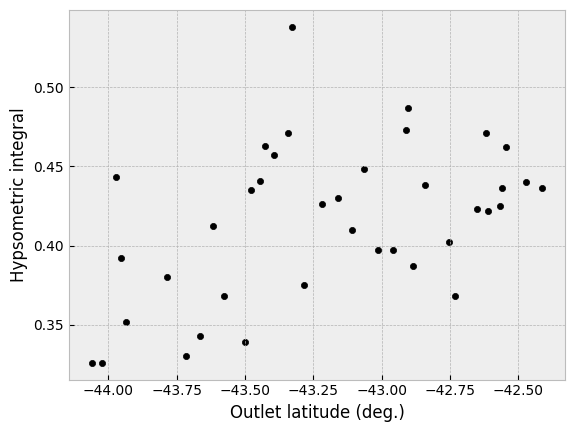

In [50]:
catchment_df.plot(
    x="Outlet latitude (deg.)", y="Hypsometric integral", kind="scatter", color="black"
);

_Hypsometric integral values as a function of latitude._

Although there is a relationship between the hypsometric integral values and latitude, the correlation appears rather weak (feel free to confirm by your own regression analysis!).

Second, it is clear that smaller watersheds generally have higher hypsometric integral values. This relationship is perhaps not a huge surprise in the rapidly uplifted landscape of the Southern Alps, where smaller watersheds have less power for erosion due to less total discharge in the rivers. Thus, the uplift of the landscape may outpace the river's erosion, resulting in a higher hypsometric integral value in small watersheds.

Again, if we look at this in a scatter plot we can clearly see the relationship between the watershed area and the hypsometric integral. In this case the correlation is stronger than that observed for latitude (again, feel free to confirm this!).

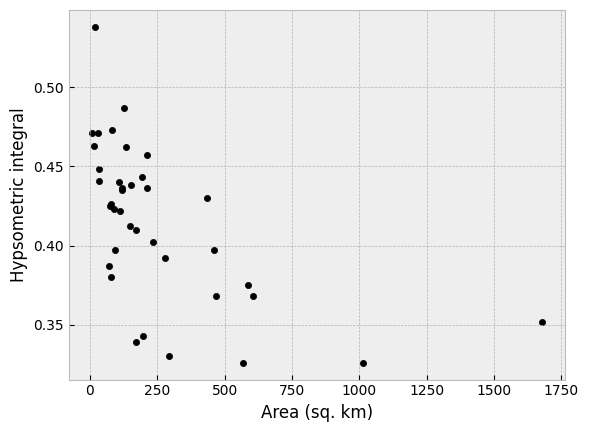

In [51]:
catchment_df.plot(
    x="Area (sq. km)", y="Hypsometric integral", kind="scatter", color="black"
);

_Hypsometric integral values as a function of watershed area._

Third, we can consider the hypsometric integral values as a function of relief in the watershed. Here too we can see that watersheds with greater relief values generally have lower hypsometric integral values. This is perhaps not a total surprise, as the watersheds with the largest relief values are also generally larger in area.

If we look at the scatter plot for this case, we can see there is a weak negative correlation between relief and hypsometric integral, but it is perhaps not as strong as the correlation for watershed area.

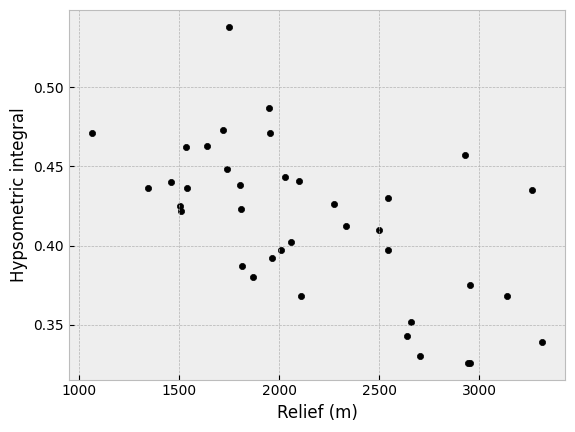

In [52]:
catchment_df.plot(
    x="Relief (m)", y="Hypsometric integral", kind="scatter", color="black"
);

_Hypsometric integral values as a function of watershed relief._

In closing, we invite you to further explore the analysis of watersheds based on the case study presented here, to add your own watershed analysis approaches or functions, and to create your own maps presenting your results in an interactive and engaging format.

## Footnotes

[^alos]: <https://www.eorc.jaxa.jp/ALOS/en/dataset/aw3d30/aw3d30_e.htm>
[^alpinefault]: <https://data.gns.cri.nz/af/>
[^elevations]: <https://en.wikipedia.org/wiki/Hypsometry>
[^fileio]: <https://mattbartos.com/pysheds/file-io.html>
[^maps]: <https://www.google.com/maps>
[^pysheds]: <https://mattbartos.com/pysheds/>
